## StarTracker Tracking drift check - 15-Mar-23

HyeYun Park - checking calibrated ra and dec during tracking

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5, SkyCoord
import astropy.units as u

In [2]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [3]:
def get_groups(df):
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    groups = np.zeros(ra.size, dtype=int)
    snakes = np.zeros(ra.size, dtype=int)
    
    diffRa = np.diff(ra)
    diffDec = np.diff(dec)
    dPnt = np.hypot(diffDec, diffRa)
    
    counter = 0
    for i in range(diffRa.size):
        #if  (dPnt[i]>1/60)&(dPnt[i]<5.): counter += 1
        if  (dPnt[i]>5.): counter += 1
        snakes[i+1] = counter
    
    #df['groups'] = groups
    df['snakes'] = snakes
    
    print('Number of Snakes:%i'%np.unique(snakes).size)
    return df

In [4]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(x)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return np.append(coefs, np.sqrt(cov[1,1]))

def get_residual(df):    
    groups = df['snakes'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        base_ra[ix] = ra[ix][0]
        base_dec[ix] = dec[ix][0]
        
        #base_ra[ix] = np.median(ra[ix])
        #base_dec[ix] = np.median(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

In [5]:
# read in dataframe
today = '2023-03-09'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [6]:
df.columns

Index(['Exposure Time wide', 'MJD wide', 'Ra wide', 'Dec wide', 'Alt wide',
       'Az wide', 'Exposure Time', 'MJD', 'Ra', 'Dec', 'Alt', 'Az', 'nSources',
       'nSources filtered', 'nSources wide', 'nSources filtered wide',
       'Calculated Ra', 'Calculated Dec', 'Calculated Alt', 'Calculated Az',
       'Delta Ra Arcsec', 'Delta Dec Arcsec', 'Delta Alt Arcsec',
       'Delta Az Arcsec', 'Delta Rot Arcsec', 'RMS scatter arcsec',
       'RMS scatter pixels', 'Calculated Ra wide', 'Calculated Dec wide',
       'Calculated Alt wide', 'Calculated Az wide', 'Delta Ra Arcsec wide',
       'Delta Dec Arcsec wide', 'Delta Alt Arcsec wide',
       'Delta Az Arcsec wide', 'Delta Rot Arcsec wide',
       'RMS scatter arcsec wide', 'RMS scatter pixels wide', 'UTC', 'UTC wide',
       'seq_num'],
      dtype='object')

In [9]:
df['Calculated Dec']*u.deg

2      -20.758235
5      -20.758223
6      -20.758304
7      -20.758334
8      -20.758314
          ...    
1794   -40.032715
1795   -37.246538
1796   -37.246565
1797   -37.246496
1798   -37.246535
Name: Calculated Dec, Length: 1767, dtype: float64

In [10]:
df['MJD']

2       60013.006798
5       60013.007125
6       60013.007235
7       60013.007344
8       60013.007453
            ...     
1794    60013.341329
1795    60013.341651
1796    60013.341753
1797    60013.341856
1798    60013.341958
Name: MJD, Length: 1767, dtype: float64

In [11]:
time = Time(df['MJD'], format='mjd', scale='utc')

In [12]:
print (len(time))
print (time)

1767
[60013.00679799 60013.00712458 60013.00723502 ... 60013.34175324
 60013.3418555  60013.34195774]


In [13]:
data = df.iloc[:].reset_index() 

In [14]:
print (data['Calculated Ra wide'])

0       147.584174
1       147.584287
2       147.584404
3       147.584426
4       147.584479
           ...    
1762    286.954783
1763    299.481642
1764    299.481693
1765    299.481718
1766    299.481791
Name: Calculated Ra wide, Length: 1767, dtype: float64


/tmp/ipykernel_31613/1490364736.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data.index, data['Calculated Ra wide'], cmap='tab20_r')


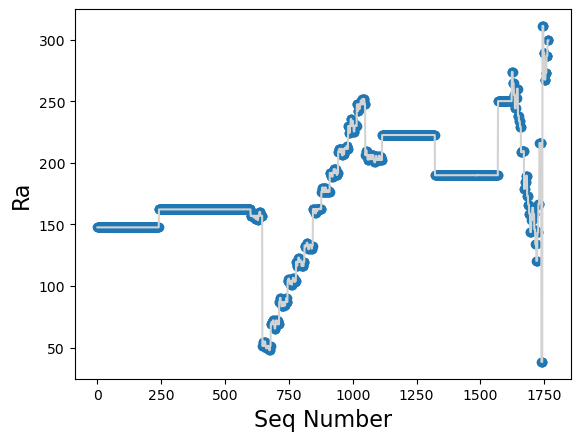

In [15]:
data['Calculated Ra wide'].plot(color='lightgray')
plt.scatter(data.index, data['Calculated Ra wide'], cmap='tab20_r')

plt.ylabel('Ra', fontsize=16)
plt.xlabel('Seq Number', fontsize=16)
plt.savefig('pointing_ra.png',dpi=100)

In [94]:
calculated_ra=data['Calculated Ra'][0:50]
calculated_dec=data['Calculated Dec'][0:50]
time=Time(data['MJD'][0:50], format='mjd', scale='utc')

In [95]:
print(time)

[60013.00679799 60013.00712458 60013.00723502 60013.00734359
 60013.00745333 60013.00756152 60013.00767322 60013.0077823
 60013.00789115 60013.00800024 60013.00811049 60013.00821984
 60013.00832749 60013.00843662 60013.00854671 60013.00865554
 60013.00876418 60013.0088726  60013.00898112 60013.00908927
 60013.00919819 60013.00930652 60013.00941645 60013.00952451
 60013.00963248 60013.00974068 60013.00984948 60013.01006654
 60013.01017503 60013.01028498 60013.01039319 60013.01050115
 60013.01060952 60013.01071954 60013.01082826 60013.01093684
 60013.01104487 60013.01126273 60013.01137169 60013.01148005
 60013.01158961 60013.01169785 60013.01180584 60013.01191381
 60013.01202329 60013.0121317  60013.01223982 60013.01234863
 60013.01245823 60013.01256623]


In [96]:
print (len(calculated_ra))
print (calculated_ra)

50
0     147.579144
1     147.579190
2     147.579218
3     147.579293
4     147.579324
5     147.579238
6     147.579305
7     147.579251
8     147.579339
9     147.579262
10    147.579255
11    147.579334
12    147.579274
13    147.579397
14    147.579297
15    147.579299
16    147.579281
17    147.579316
18    147.579315
19    147.579348
20    147.579370
21    147.579376
22    147.579396
23    147.579420
24    147.579390
25    147.579376
26    147.579451
27    147.579432
28    147.579362
29    147.579513
30    147.579577
31    147.579523
32    147.579610
33    147.579648
34    147.579618
35    147.579539
36    147.579378
37    147.579582
38    147.579621
39    147.579701
40    147.579698
41    147.579600
42    147.579723
43    147.579545
44    147.579643
45    147.579575
46    147.579719
47    147.579716
48    147.579753
49    147.579705
Name: Calculated Ra, dtype: float64


In [97]:
print (time.utc)

[60013.00679799 60013.00712458 60013.00723502 60013.00734359
 60013.00745333 60013.00756152 60013.00767322 60013.0077823
 60013.00789115 60013.00800024 60013.00811049 60013.00821984
 60013.00832749 60013.00843662 60013.00854671 60013.00865554
 60013.00876418 60013.0088726  60013.00898112 60013.00908927
 60013.00919819 60013.00930652 60013.00941645 60013.00952451
 60013.00963248 60013.00974068 60013.00984948 60013.01006654
 60013.01017503 60013.01028498 60013.01039319 60013.01050115
 60013.01060952 60013.01071954 60013.01082826 60013.01093684
 60013.01104487 60013.01126273 60013.01137169 60013.01148005
 60013.01158961 60013.01169785 60013.01180584 60013.01191381
 60013.01202329 60013.0121317  60013.01223982 60013.01234863
 60013.01245823 60013.01256623]


In [98]:
time.format='fits'
print (time)

['2023-03-10T00:09:47.346' '2023-03-10T00:10:15.564'
 '2023-03-10T00:10:25.105' '2023-03-10T00:10:34.486'
 '2023-03-10T00:10:43.968' '2023-03-10T00:10:53.315'
 '2023-03-10T00:11:02.966' '2023-03-10T00:11:12.391'
 '2023-03-10T00:11:21.795' '2023-03-10T00:11:31.221'
 '2023-03-10T00:11:40.747' '2023-03-10T00:11:50.195'
 '2023-03-10T00:11:59.496' '2023-03-10T00:12:08.924'
 '2023-03-10T00:12:18.436' '2023-03-10T00:12:27.839'
 '2023-03-10T00:12:37.225' '2023-03-10T00:12:46.593'
 '2023-03-10T00:12:55.969' '2023-03-10T00:13:05.313'
 '2023-03-10T00:13:14.724' '2023-03-10T00:13:24.083'
 '2023-03-10T00:13:33.581' '2023-03-10T00:13:42.918'
 '2023-03-10T00:13:52.247' '2023-03-10T00:14:01.594'
 '2023-03-10T00:14:10.995' '2023-03-10T00:14:29.749'
 '2023-03-10T00:14:39.123' '2023-03-10T00:14:48.622'
 '2023-03-10T00:14:57.971' '2023-03-10T00:15:07.300'
 '2023-03-10T00:15:16.663' '2023-03-10T00:15:26.168'
 '2023-03-10T00:15:35.562' '2023-03-10T00:15:44.943'
 '2023-03-10T00:15:54.277' '2023-03-10T00:16:1

In [99]:
date=time.strftime('%Y %b %d')[0]
time=time.strftime('%H:%M:%S') #%d %b %Y')

Text(0.5, 0.98, 'Calculated Ra&Dec 2023 Mar 10')

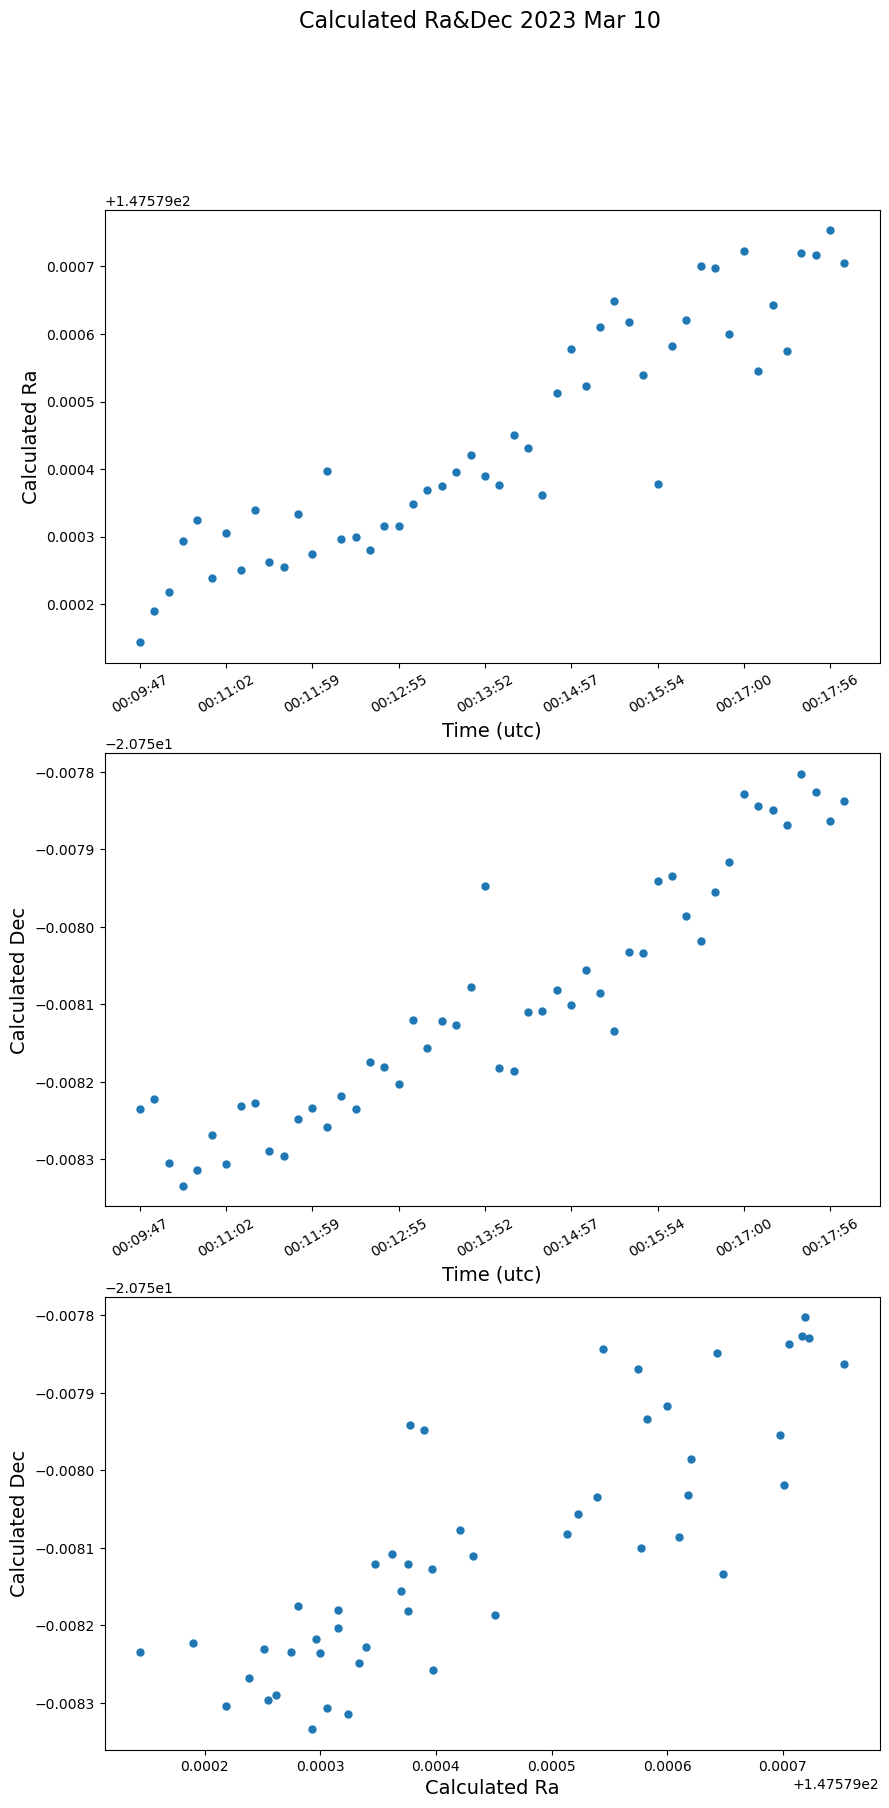

In [103]:
fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize=(10,20))
fig.subplots_adjust(wspace=0.)

ax1.scatter(np.array(time),np.array(calculated_ra),  s=25)
ax2.scatter(np.array(time),np.array(calculated_dec), s=25)

ax1.set_ylabel('Calculated Ra',fontsize=14)
ax1.set_xlabel('Time (utc)',fontsize=14)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
#ax1.set_ylim(np.min(calculated_ra)-0.001,np.max(calculated_ra)+0.001)
ax1.tick_params(axis='x', labelrotation=30)

ax2.set_ylabel('Calculated Dec',fontsize=14)
ax2.set_xlabel('Time (utc)',fontsize=14)
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.tick_params(axis='x', labelrotation=30)
#ax2.set_ylim(np.min(calculated_dec)-0.001,np.max(calculated_dec)+0.001)

ax3.scatter(np.array(calculated_ra), np.array(calculated_dec), s=25)
ax3.set_ylabel('Calculated Dec',fontsize=14)
ax3.set_xlabel('Calculated Ra',fontsize=14)

fig.suptitle('Calculated Ra&Dec %s'%date,fontsize=16)



In [ ]:
df.columns